<a href="https://colab.research.google.com/github/bartolomeoadrian/computer-vision/blob/main/exam_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [14]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

# Video original

In [2]:
video_url = 'https://raw.githubusercontent.com/bartolomeoadrian/computational-vision/refs/heads/main/assets/videos/football_match.mp4'
r = requests.get(video_url)

with open("/content/football_match.mp4", "wb") as f:
    f.write(r.content)

# Función auxiliar para dibujar imagenes

In [3]:
def show_images(images, rows=1, cols=2, figsize=(12, 8)):
    plt.figure(figsize=figsize)
    for i, (title, img) in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap="gray" if img.ndim==2 else None)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Imagen para realizar pruebas

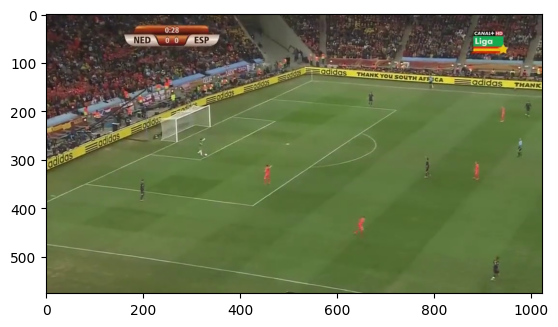

In [4]:
cap = cv2.VideoCapture('/content/football_match.mp4')

cap.set(cv2.CAP_PROP_POS_MSEC, 30 * 1000)

ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

if ret:
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("No se pudo leer el frame.")

# Funciones auxiliares

In [5]:
def segment_field_green(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    lower_green = np.array([35, 40, 40], dtype=np.uint8)
    upper_green = np.array([85, 255, 255], dtype=np.uint8)

    mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Keep only the largest contour (field)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        filled = np.zeros_like(mask)
        cv2.drawContours(filled, [largest], -1, 255, thickness=cv2.FILLED)
        return filled
    return mask

def draw_lines(canvas, lines, color=(255, 255, 0), thickness=2):
    """
    Draw Hough lines on the canvas.
    """
    if lines is None:
        return
    for ln in lines:
        x1, y1, x2, y2 = ln[0]
        cv2.line(canvas, (x1, y1), (x2, y2), color, thickness)

# Función para dibujar límites de la cancha

In [6]:
def draw_field(frame, canvas):
    """
    Detect white straight lines within the green field area using Canny + HoughLinesP.
    """
    # Keep only the field area
    field_mask = segment_field_green(frame)
    field_only = cv2.bitwise_and(frame, frame, mask=field_mask)

    # Detect edges
    gray = cv2.cvtColor(field_only, cv2.COLOR_BGR2GRAY)
    edges_gray = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Hough probabilistic
    lines = cv2.HoughLinesP(
        edges_gray,
        rho=1,
        theta=np.pi/180,
        threshold=80,
        minLineLength=80,
        maxLineGap=10
    )

    draw_lines(canvas, lines, color=(255, 255, 0), thickness=2)

# Detección de limites de la cancha

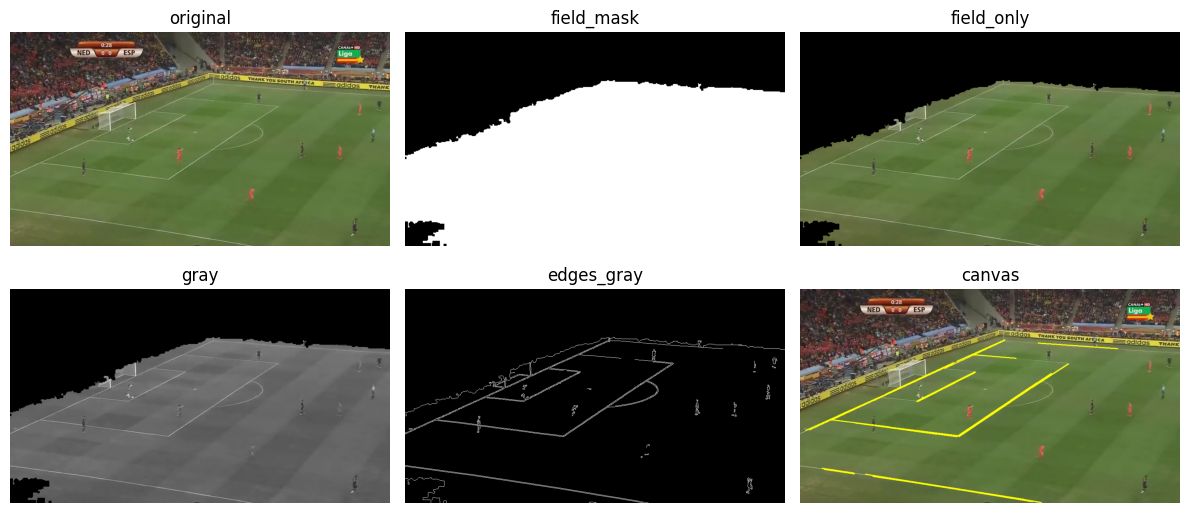

In [7]:
# Segment field
field_mask = segment_field_green(frame_rgb)
field_only = cv2.bitwise_and(frame_rgb, frame_rgb, mask=field_mask)

# Detect edges
gray = cv2.cvtColor(field_only, cv2.COLOR_BGR2GRAY)
edges_gray = cv2.Canny(gray, 50, 150, apertureSize=3)

# Hough probabilistic
lines = cv2.HoughLinesP(
    edges_gray,
    rho=1,
    theta=np.pi/180,
    threshold=80,
    minLineLength=80,
    maxLineGap=10
)

# Final result
canvas = frame_rgb.copy()
draw_field(frame_rgb, canvas)

show_images([
    ("original", frame_rgb),
    ("field_mask", field_mask),
    ("field_only", field_only),
    ("gray", gray),
    ("edges_gray", edges_gray),
    ("canvas", canvas)
], rows=3, cols=3)

# Función para detectar jugadores en cancha

In [8]:
def detect_players_by_color(frame, canvas, jersey_rgb, tol=40,
                            min_area=40, max_area=600,
                            box_color=(0,0,255), thickness=2, margin=10):
    field_mask = segment_field_green(frame)

    r, g, b = jersey_rgb
    lower = np.array([max(0,   r - tol), max(0,   g - tol), max(0,   b - tol)], dtype=np.uint8)
    upper = np.array([min(255, r + tol), min(255, g + tol), min(255, b + tol)], dtype=np.uint8)

    team_mask = cv2.inRange(frame, lower, upper)
    team_mask = cv2.bitwise_and(team_mask, field_mask)

    boxes = []
    cnts, _ = cv2.findContours(team_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in cnts:
        a = cv2.contourArea(c)
        if min_area <= a <= max_area:
            x,y,w,h = cv2.boundingRect(c)
            if h > w and h > 10:
                boxes.append((x,y,w,h))

                x1 = max(0, x - margin)
                y1 = max(0, y - margin)
                x2 = min(frame.shape[1], x + w + margin)
                y2 = min(frame.shape[0], y + h + margin)

                cv2.rectangle(canvas, (x1, y1), (x2, y2), box_color, thickness)


# Detectar jugadores por color de camiseta y dentro de la cancha

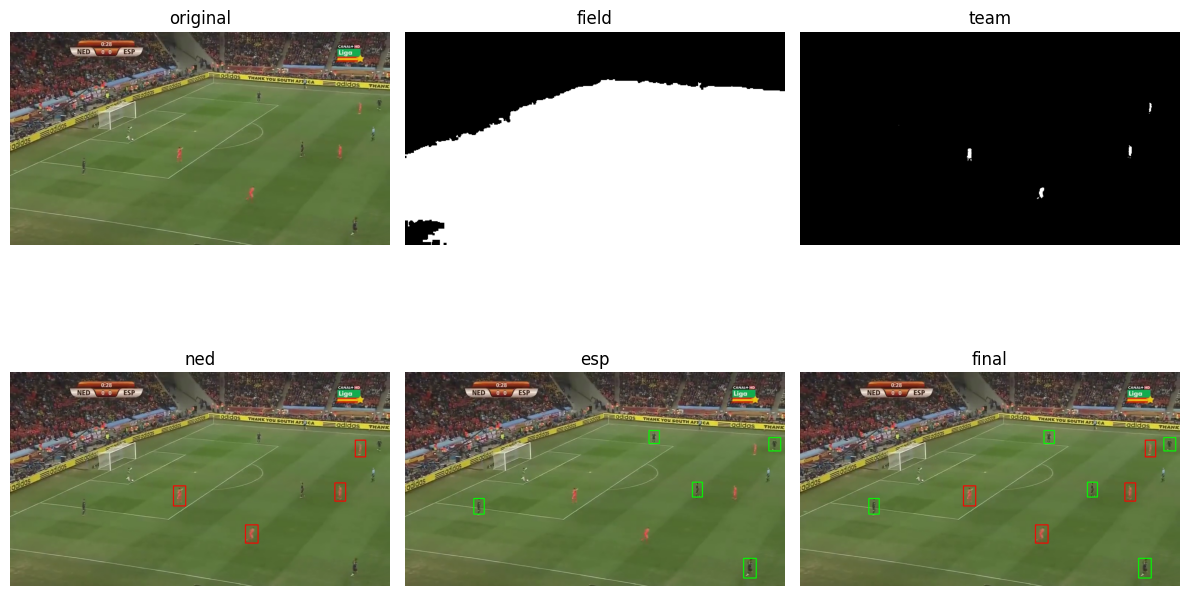

In [9]:
# Example
field_mask = segment_field_green(frame_rgb)

ned_tol = 60
r, g, b = (200, 83, 73)
lower = np.array([max(0,   r - ned_tol), max(0,   g - ned_tol), max(0,   b - ned_tol)], dtype=np.uint8)
upper = np.array([min(255, r + ned_tol), min(255, g + ned_tol), min(255, b + ned_tol)], dtype=np.uint8)

team_mask = cv2.inRange(frame_rgb, lower, upper)
team_mask = cv2.bitwise_and(team_mask, field_mask)

# Implementation
ned = frame_rgb.copy()
detect_players_by_color(frame_rgb, ned, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))

esp = frame_rgb.copy()
detect_players_by_color(frame_rgb, esp, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))

final = frame_rgb.copy()
detect_players_by_color(frame_rgb, final, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))
detect_players_by_color(frame_rgb, final, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))

show_images([
    ("original", frame_rgb),
    ("field", field_mask),
    ("team", team_mask),
    ("ned", ned),
    ("esp", esp),
    ("final", final),
], rows=2, cols=3)


# Función para detectar pelota

In [10]:
def detect_ball(frame, canvas,
                dp=1.2, min_dist=20,
                param1=100, param2=15,
                min_r=4, max_r=20):
    # Field mask
    field_mask = segment_field_green(frame)
    field_only = cv2.bitwise_and(frame, frame, mask=field_mask)

    # Gray + Blur mask
    gray = cv2.cvtColor(field_only, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # HoughCircles
    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT,
        dp=dp, minDist=min_dist,
        param1=param1, param2=param2,
        minRadius=min_r, maxRadius=max_r
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        x,y,r = circles[0][0]
        cv2.circle(canvas, (x,y), r, (0,255,0), 2)
        cv2.circle(canvas, (x,y), 2, (0,0,255), 3)
        return (x,y,r)

# Detectar pelota

In [11]:
!pip -q install ultralytics
from ultralytics import YOLO
model = YOLO('yolo11m.pt')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


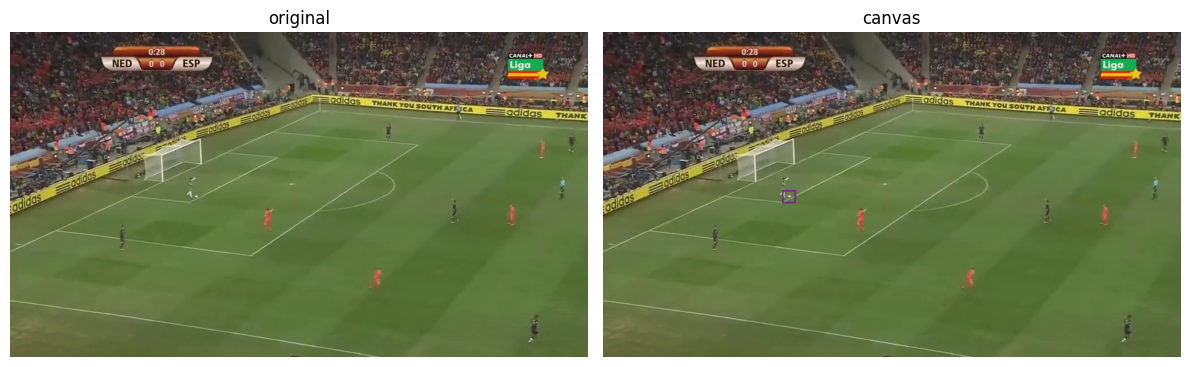

In [15]:
def detect_ball_yolo_fast(frame_rgb, canvas, model,
                          k_candidates=3, crop_size=224,
                          conf=0.05, iou=0.3, margin=8,
                          color=(120, 40, 140), thickness=2):
    h, w = frame_rgb.shape[:2]

    # 1) Segmentación de cancha (ya la tenés)
    field_mask = segment_field_green(frame_rgb)
    field = cv2.bitwise_and(frame_rgb, frame_rgb, mask=field_mask)

    # 2) Prefiltro barato de "blancos" y circularidad → candidatos
    hsv = cv2.cvtColor(field, cv2.COLOR_RGB2HSV)
    # blanco/gris claro sobre césped
    # ajustá estos rangos si hay sobreexposición o nieve de ruido
    lower = np.array([0,   0, 180], dtype=np.uint8)
    upper = np.array([179, 60, 255], dtype=np.uint8)
    mask_white = cv2.inRange(hsv, lower, upper)
    # limpiamos ruido finito
    mask_white = cv2.medianBlur(mask_white, 5)
    mask_white = cv2.morphologyEx(mask_white, cv2.MORPH_OPEN,
                                  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))

    cnts, _ = cv2.findContours(mask_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    candidates = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 6 or area > 300:  # la pelota es muy chica a vista aérea
            continue
        per = cv2.arcLength(c, True) + 1e-6
        circ = 4*np.pi*area/(per*per)  # 1 = círculo perfecto
        if circ < 0.5:  # descartá manchas alargadas
            continue
        (cx, cy), r = cv2.minEnclosingCircle(c)
        cx, cy, r = int(cx), int(cy), int(max(2, r))
        candidates.append((circ, area, (cx, cy, r)))

    # quedate con los k mejores por circularidad y tamaño
    candidates.sort(key=lambda x: (x[0], x[1]), reverse=True)
    candidates = candidates[:k_candidates]

    if not candidates:
        return  # sin candidatos, evitamos correr YOLO a tamaño gigante

    # 3) Armá crops cuadrados alrededor del candidato y corré YOLO en batch
    crops = []
    boxes_map = []  # para mapear cada crop al espacio original
    half = crop_size // 2

    for _, _, (cx, cy, r) in candidates:
        x1 = max(0, cx - half); y1 = max(0, cy - half)
        x2 = min(w, cx + half); y2 = min(h, cy + half)
        crop = field[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        crops.append(crop)
        boxes_map.append((x1, y1, x2, y2))

    if not crops:
        return

    # Automatically select device (GPU if available, otherwise CPU)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Ultralytics acepta lista de imágenes → inferencia en batch
    res = model(crops, imgsz=320, conf=conf, iou=iou,
                classes=[32], max_det=1, verbose=False, device=device)

    # 4) Elegí la mejor detección global y remapeá al canvas
    best = None  # (conf, (x1,y1,x2,y2) en coords full-frame)
    for det, (bx1, by1, bx2, by2) in zip(res, boxes_map):
        if len(det.boxes):
            i = int(det.boxes.conf.argmax())
            x1c, y1c, x2c, y2c = det.boxes.xyxy[i].tolist()
            score = float(det.boxes.conf[i])

            # remap a coords del frame
            x1 = int(bx1 + x1c); y1 = int(by1 + y1c)
            x2 = int(bx1 + x2c); y2 = int(by1 + y2c)

            if best is None or score > best[0]:
                best = (score, (x1, y1, x2, y2))

    if best:
        _, (x1, y1, x2, y2) = best
        # margen y clipping
        x1 = max(0, x1 - margin); y1 = max(0, y1 - margin)
        x2 = min(w, x2 + margin); y2 = min(h, y2 + margin)
        cv2.rectangle(canvas, (x1, y1), (x2, y2), color, thickness)

canvas = frame_rgb.copy()
detect_ball_yolo_fast(frame_rgb, canvas, model)

show_images([
    ("original", frame_rgb),
    ("canvas", canvas)
], rows=1, cols=2)

# Generar video

In [13]:
cap = cv2.VideoCapture('/content/football_match.mp4')

# YOLO Model
model = YOLO('yolo11m.pt')

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define output video writer
out = cv2.VideoWriter('/content/football_match_final.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Process frames
with tqdm(total=total_frames, desc='Processing video') as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb_final_video = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        canvas = frame_rgb_final_video.copy()
        canvas = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

        draw_field(frame_rgb_final_video, canvas)
        detect_players_by_color(frame_rgb_final_video, canvas, tol=60, jersey_rgb=(200, 83, 73), box_color=(255,0,0))
        detect_players_by_color(frame_rgb_final_video, canvas, tol=40, jersey_rgb=(47, 50, 41), box_color=(0,255,0))
        detect_ball_yolo_fast(frame_rgb_final_video, canvas, model)

        out.write(canvas)
        pbar.update(1)

cap.release()
out.release()

Processing video:  30%|██▉       | 2244/7517 [31:30<1:14:01,  1.19it/s]


KeyboardInterrupt: 

# Resultado